<a href="https://colab.research.google.com/github/Liying1996/DL_Drugs/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_absolute_deviation

from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR 
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import pearsonr
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [ ]:
!nvidia-smi

Wed Feb  3 01:28:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    22W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from torch.utils.data import Dataset, DataLoader

class RegressionDataset(Dataset):   
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [ ]:
# VAE model
class VAE(nn.Module):
    def __init__(self, input_size):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_size, 5000)
        self.fc2 = nn.Linear(5000, 2000)
        self.fc3 = nn.Linear(2000, 500)
        self.fc41 = nn.Linear(500, 100)
        self.fc42 = nn.Linear(500, 100) 
        self.fc5 = nn.Linear(100, 500)
        self.fc6 = nn.Linear(500, 2000)
        self.fc7 = nn.Linear(2000, 5000)
        self.fc8 = nn.Linear(5000, input_size)
        
    # 编码
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.fc41(h), self.fc42(h)
    
    # 随机生成隐含向量
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    # 解码
    def decode(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        h = F.relu(self.fc7(h))
        return torch.sigmoid(self.fc8(h))
    
    # 前向传播
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [ ]:
# python读取
import pandas as pd
import numpy as np

bortezomib = pd.read_csv("gdrive/MyDrive/AE_results/Data/bortezomib_cells.txt", sep = "\t")
# bortezomib.head(5)
cisplatin = pd.read_csv("gdrive/MyDrive/AE_results/Data/cisplatin-occams_cells.txt", sep = "\t")
paclitaxel = pd.read_csv("gdrive/MyDrive/AE_results/Data/paclitaxel_cells.txt", sep = "\t")
parpi = pd.read_csv("gdrive/MyDrive/AE_results/Data/parpi_cells.txt", sep = "\t")

In [ ]:
data = parpi
scaler = MinMaxScaler()
new_data = scaler.fit_transform(data.iloc[:,1:])
all_data, all_labels = np.array(new_data), np.array(data.iloc[:,0])
all_dataset = RegressionDataset(torch.from_numpy(all_data).float(), torch.from_numpy(all_labels).float())
all_loader = DataLoader(dataset=all_dataset, batch_size=20)

In [ ]:
batch_size = 20
learning_rate = 1e-3

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = VAE(data.shape[1]-1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


In [ ]:
all_loss = []
for epoch in range(200):
    train_loss = 0
    for i, (x, _) in enumerate(all_loader):
        # 获取样本，并前向传播
        x = x.to(device)
        x_reconst, mu, log_var = model(x)
        
        # 计算重构损失和KL散度（KL散度用于衡量两种分布的相似程度）
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconst_loss + kl_div
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
    
    all_loss.append(train_loss / len(all_loader))      
    if not epoch%50:
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(all_loader)))
    

====> Epoch: 0 Average loss: 204903.5658
====> Epoch: 50 Average loss: 189998.2035
====> Epoch: 100 Average loss: 188635.2969
====> Epoch: 150 Average loss: 188184.2846


In [ ]:
x_reconst, mu, log_var = model(torch.from_numpy(new_data).float().cuda())

In [ ]:
x_encoder = VAE(data.shape[1]-1).reparameterize(mu, log_var)

In [ ]:
x_encoder.shape

torch.Size([837, 100])

In [ ]:
x_encoder.cpu().detach().numpy()[~np.isnan(all_labels)].shape

(779, 100)

In [ ]:
encoder_nona = x_encoder.cpu().detach().numpy()[~np.isnan(all_labels)]
labels_nona = all_labels[~np.isnan(all_labels)]

In [ ]:
from sklearn.model_selection import train_test_split
train_encoder, test_encoder, y_train, y_test = train_test_split(x_encoder.cpu().detach().numpy()[~np.isnan(all_labels)], 
                                                                all_labels[~np.isnan(all_labels)], test_size=0.3)

In [ ]:
from sklearn.svm import SVR 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:

rbf_svr = SVR(kernel='rbf', C=1.5)
rbf_svr.fit(train_encoder, y_train)
rbf_svr_predict = rbf_svr.predict(test_encoder)

print(mean_squared_error(y_test, rbf_svr_predict))
print(r2_score(y_test, rbf_svr_predict))

1.0777344536401066
-0.08900897681028619


In [ ]:
from sklearn.model_selection import cross_val_score

print(np.mean(cross_val_score(rbf_svr, encoder_nona, labels_nona, cv=5, scoring="neg_mean_squared_error")))
print(np.mean(cross_val_score(rbf_svr, encoder_nona, labels_nona, cv=5, scoring="r2")))

-1.047925519241245
-0.06099056270929615


In [ ]:
# PCA

from sklearn.decomposition import PCA 

pca = PCA(n_components=100)
pca.fit(all_data)
# print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
# print(pca.explained_variance_)

0.62009334040444


In [ ]:
X_new = pca.transform(all_data)
X_new.shape

(837, 100)

In [ ]:
X_new_nona = X_new[~np.isnan(all_labels)]
labels_nona = all_labels[~np.isnan(all_labels)]

In [ ]:
print(np.mean(cross_val_score(rbf_svr, X_new_nona, labels_nona, cv=5, scoring="neg_mean_squared_error")))
print(np.mean(cross_val_score(rbf_svr, X_new_nona, labels_nona, cv=5, scoring="r2")))

-0.7686242168292816
0.22054563678638517


In [ ]:
# UMAP

import umap

In [ ]:
reducer = umap.UMAP(n_components=100)
X_new = reducer.fit_transform(all_data)

In [ ]:
X_new_nona = X_new[~np.isnan(all_labels)]
labels_nona = all_labels[~np.isnan(all_labels)]

print(np.mean(cross_val_score(rbf_svr, X_new_nona, labels_nona, cv=5, scoring="neg_mean_squared_error")))
print(np.mean(cross_val_score(rbf_svr, X_new_nona, labels_nona, cv=5, scoring="r2")))

-0.8657544681571029
0.12252011064954751


In [ ]:
import scipy.io as scio
data_file = 'gdrive/MyDrive/AE_results/MC_PR_Data/CCLE_X.mat'
data = scio.loadmat(data_file)
gene_expr = data['X']


In [ ]:
labels_file = 'gdrive/MyDrive/AE_results/MC_PR_Data/MMnormal.mat'
labels_data = scio.loadmat(labels_file)
labels = labels_data['MM']

In [ ]:
# VAE model
class VAE(nn.Module):
    def __init__(self, input_size):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_size, 3000)
        self.fc21 = nn.Linear(3000, 500)
        self.fc22 = nn.Linear(3000, 500)
        self.fc3 = nn.Linear(500, 3000)
        self.fc4 = nn.Linear(3000, input_size)
        
    # 编码
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)
    
    # 随机生成隐含向量
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    # 解码
    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = self.fc4(h)
        return torch.sigmoid(h)
        # return h
    
    # 前向传播
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


In [ ]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    # x_recon ist der im forward im Model erstellte recon_batch, x ist der originale x Batch, mu ist mu und logvar ist logvar 
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD 

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    loss = nn.MSELoss(reduction="sum")
    loss_MSE = loss(recon_x, x)
    loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss_MSE + loss_KLD

In [ ]:
def scale_data(X_train, X_test):
    scaler = MinMaxScaler()
    new_X_train = scaler.fit_transform(X_train)
    new_X_test = scaler.transform(X_test)
    return new_X_train, new_X_test

def top_mad(X_train, X_test, cut):    
    index = np.argsort(-median_absolute_deviation(X_train))
    new_index = index[:int(X_train.shape[1] * cut)]
    X_train = X_train[:,new_index]
    X_test = X_test[:,new_index]
    return X_train, X_test

def classic_reg(X_train, y_train, X_test, method):
    if method == 'rf':
        rg = RandomForestRegressor()
    if method == 'svr':
        rg = SVR(kernel='rbf')
    if method == 'elasticnet':
        rg = ElasticNet()

    rg.fit(X_train, y_train)
    test_pred = rg.predict(X_test)
    return test_pred

def evaluate(y_test, test_pred):
    r2 = r2_score(y_test, test_pred)
    mse = mean_squared_error(y_test, test_pred)   
    pccs = pearsonr(y_test, test_pred)
    
    # print("Method = {}, r2_score = {}, MSE = {}, PCC = {}, PCC_p".format(method, r2, mse, pccs[0], pccs[1]))
    return r2, mse, pccs[0]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(gene_expr, labels[:,3], test_size=0.2, random_state=42)

X_train, X_test = top_mad(X_train, X_test, cut=0.5)
X_train, X_test = scale_data(X_train, X_test)

train_loader = DataLoader(dataset=torch.from_numpy(X_train).float(), batch_size=30)   
test_loader = DataLoader(dataset=torch.from_numpy(X_test).float(), batch_size=30)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
input_size
x.shape

torch.Size([30, 9450])

epoch = 0, train loss = 25179.568320138114, test_loss = 8524.710083007812;
epoch = 20, train loss = 7437.389487130301, test_loss = 6640.682189941406;
epoch = 40, train loss = 6915.392547607422, test_loss = 6446.5809326171875;
epoch = 60, train loss = 6691.260332380022, test_loss = 6305.5955810546875;
epoch = 80, train loss = 6519.506652832031, test_loss = 6397.867248535156;
epoch = 100, train loss = 6472.241657802037, test_loss = 6311.5721435546875;
epoch = 120, train loss = 6271.18739100865, test_loss = 6502.6025390625;
epoch = 140, train loss = 6219.620147705078, test_loss = 6420.85595703125;
epoch = 160, train loss = 6273.817308698382, test_loss = 6636.983154296875;
epoch = 180, train loss = 6505.756356375558, test_loss = 6770.0677490234375;


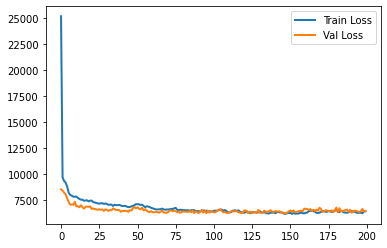

In [ ]:
input_size = X_train.shape[1]
model2 = VAE(input_size).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)  

all_train_loss = []
all_test_loss = []

for epoch in range(200):
    train_loss = 0
    model2.train()
    for x in train_loader:   
        # model2.train()   
        x = x.cuda()
        x_reconst, mu, log_var = model2(x)
        loss = loss_function(x_reconst, x, mu, log_var)

        # backprop
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
    
    with torch.no_grad():
        model2.eval()
        test_loss = 0

        for x in test_loader:
            # model2.eval()
            x = x.cuda()

            x_reconst, mu, log_var = model2(x)
            loss = loss_function(x_reconst, x, mu, log_var)

            test_loss += loss.item()

    all_train_loss.append(train_loss/len(train_loader))
    all_test_loss.append(test_loss/len(test_loader))
    if epoch % 20 == 0:
        print('epoch = {}, train loss = {}, test_loss = {};'.format(epoch,\
                                            train_loss/len(train_loader), test_loss/len(test_loader)))
    
plt.plot([x for x in range(200)], all_train_loss, label='Train Loss', linewidth=2)
plt.plot([y for y in range(200)], all_test_loss, label='Val Loss', linewidth=2)
plt.legend()
plt.show()

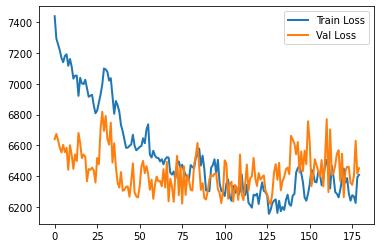

In [ ]:
    
plt.plot([x for x in range(180)], all_train_loss[20:], label='Train Loss', linewidth=2)
plt.plot([y for y in range(180)], all_test_loss[20:], label='Val Loss', linewidth=2)
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
x_reconst, train_encoder, log_var = model2(torch.from_numpy(X_train).float().cuda())
x_reconst, test_encoder, log_var = model2(torch.from_numpy(X_test).float().cuda())

In [ ]:
X_train = train_encoder.cpu().detach().numpy()
X_test = test_encoder.cpu().detach().numpy()

In [ ]:
np.sum(np.all(np.equal(X_test, 0), axis=0))

0

In [ ]:
methods = ['rf', 'svr']
all_r2 = [0, 0]
all_mse = [0, 0]
all_pcc = [0, 0]
for j in range(2):
    test_pred = classic_reg(X_train, y_train, X_test, method=methods[j])
    r2, mse, pcc = evaluate(y_test, test_pred)
    all_r2[j] += r2
    all_mse[j] += mse
    all_pcc[j] += pcc
print(all_r2)
print(all_mse)
print(all_pcc)

[0.3872046592821007, 0.3566256168012716]
[0.5644027933531994, 0.592567003893748]
[0.6258431087467016, 0.628376624649286]
